# Example usage: upper-air waviness metrics
Entire notebook takes 4 seconds to run on Intel i7-10750
## Index
[Francis & Vavrus 2015](#Francis-&-Vavrus-2015)  
[Cattiaux et al. 2016](#Cattiaux-et-al.-2016)  

preprint describing the package: https://egusphere.copernicus.org/preprints/2023/egusphere-2023-661/

In [1]:
## For calculation of jet latitude and speed statistics
import numpy as np
import xarray as xr
import jsmetrics
print("xarray version:", xr.__version__) ## tested on 0.1.3
print("jsmetrics version:", jsmetrics.__version__) ## tested on 2023.3.0

## For plotting
import matplotlib.pyplot as plt

xarray version: 2023.3.0
jsmetrics version: 0.1.6


## load in and format ERA5 data

In [2]:
ua = xr.open_dataset('data/era5_u_wind_JF21.nc')
va = xr.open_dataset('data/era5_v_wind_JF21.nc')
zg = xr.open_dataset('data/era5_zg_wind_JF21.nc')


In [3]:
## this is necessary because jsmetrics currently only accept standardised names as input. This may change in the future
ua = ua.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'u':'ua'})
va = va.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'v':'va'})
zg = zg.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev'})


In [4]:
va

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 91, plev: 6, time: 59)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 85.0 ... 4.0 3.0 2.0 1.0 0.0
  * plev     (plev) int32 100 250 300 500 700 850
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-02-28
Data variables:
    va       (time, plev, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:57:36 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

## Calculate metrics

### Francis & Vavrus 2015

In [5]:
jsmetrics.waviness_metrics.francis_vavrus_2015?

Signature: jsmetrics.waviness_metrics.francis_vavrus_2015(data)
Docstring:
This method calculates a waviness metric called: Meridional Circulation Index (MCI) from u- and v-components of wind.

MCI is calculated as follows:

.. math::
    MCI = \frac{v*|v|}{u^2+v^2}

When MCI = 0, the wind is purely zonal, and when MCI= 1 (-1), the flow is from the South (North).

This method was originally introduce in Francis & Vavrus (2015) https://doi.org/10.1088/1748-9326/10/1/014005
and is described in the Section entitled: 'Meridional circulation Index (MCI)'.

Please see 'Notes' below for any additional information about the implementation of this method
to this package.

Parameters
----------
data : xarray.Dataset
    Data which should containing the variables: 'ua' and 'va', and the coordinates: 'lon', 'lat', 'plev' and 'time'.

Returns
----------
output : xarray.Dataset
    Data containing the one output: 'mci'

Notes
-----
In the original methodology, MCI is expressed in terms of seasonal a

In [6]:
uava = xr.merge([ua, va])

In [25]:
%%time
# This takes ~50 milliseconds on Intel i7-10750
mci = jsmetrics.waviness_metrics.francis_vavrus_2015(\
                                        uava.sel(time="2021-02", plev=500, lat=slice(90, 0)))

CPU times: user 50.5 ms, sys: 4.87 ms, total: 55.4 ms
Wall time: 52.4 ms


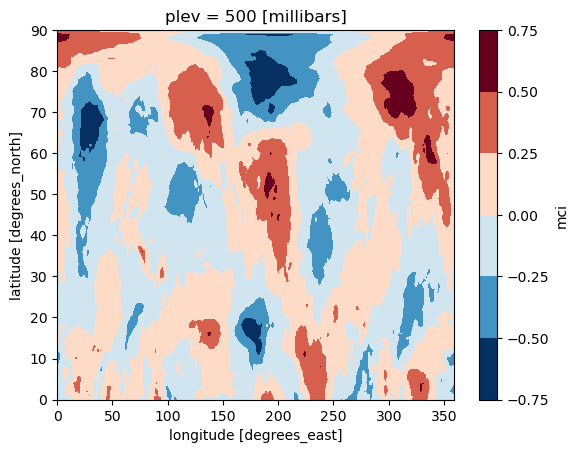

In [28]:
mci['mci'].mean('time').plot.contourf()

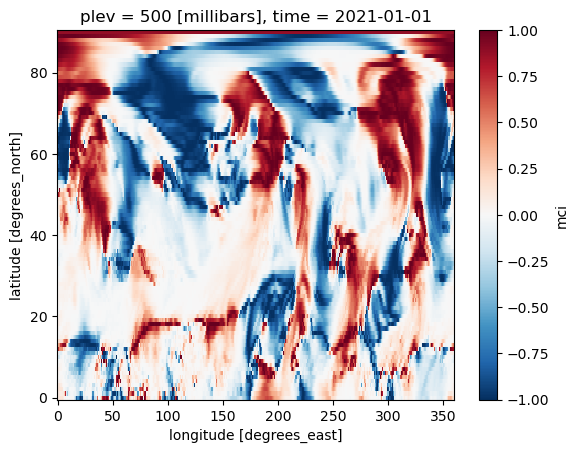

In [10]:
mci['mci'].isel(time=0).plot()

### Cattiaux et al. 2016

In [33]:
%%time
# In this example we look at North Hemispheric sinuosity
# This takes 4 seconds on Intel i7-10750
c16 = jsmetrics.waviness_metrics.cattiaux_et_al_2016(zg.sel(time="2021-02"))

CPU times: user 1.99 s, sys: 11.3 ms, total: 2 s
Wall time: 1.99 s


In [38]:
c16

<xarray.Dataset>
Dimensions:                 (lon: 360, lat: 91, time: 28)
Coordinates:
  * lon                     (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                     (lat) float32 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
    plev                    int32 500
  * time                    (time) datetime64[ns] 2021-02-01 ... 2021-02-28
Data variables:
    zg                      (time, lat, lon) float32 5.869e+03 ... 5.132e+03
    zonal_mean_zg_30Nto70N  (time) float32 5.399e+03 5.395e+03 ... 5.418e+03
    sinuosity               (time) float64 1.507 1.573 1.649 ... 1.284 1.305
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 14:40:00 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [43]:
mci_feb21 = mci['mci'].mean('time')

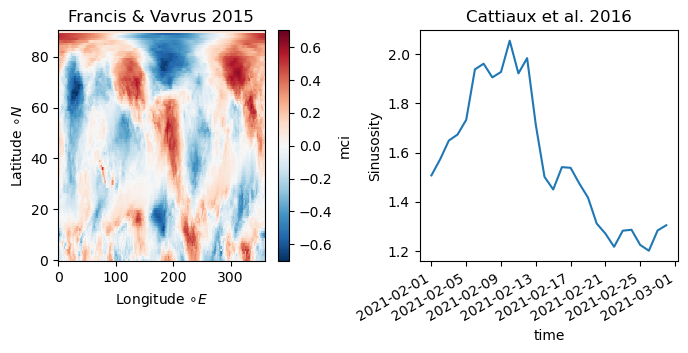

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
mci_feb21.plot(ax=axes[0])
c16['sinuosity'].plot(ax=axes[1])
axes[0].set_ylabel("Latitude $\circ N$")
axes[0].set_xlabel("Longitude $\circ E$")
axes[0].set_title("Francis & Vavrus 2015")
axes[1].set_ylabel("Sinusosity")
axes[1].set_title("Cattiaux et al. 2016")
fig.subplots_adjust(wspace=.4)
# fig.savefig("fv15_c16_example.png", bbox_inches='tight')

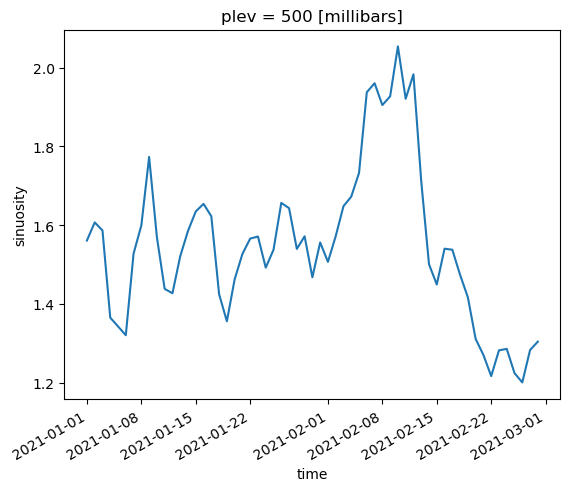

In [24]:
c16['sinuosity'].plot()